https://arxiv.org/abs/1609.09430
https://tfhub.dev/google/vggish/1
https://github.com/tensorflow/models/tree/master/research/audioset/vggish

In [4]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio



In [5]:
# Load the model.
vgg_model = hub.load('https://tfhub.dev/google/vggish/1')

# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(3 * 16000, dtype=np.float32)

# Run the model, check the output.
embeddings = vgg_model(waveform)
embeddings.shape.assert_is_compatible_with([None, 128])

In [12]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [6]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
my_classes = ['thunderstorm', 'vacuum_cleaner', 'chirping_birds', 'dog']
map_class_to_id = {'thunderstorm':0, 'vacuum_cleaner':1, 'chirping_birds':2, 'dog':3}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,3,dog,True,100032,A
1,./datasets/ESC-50-master/audio/1-100038-A-14.wav,1,2,chirping_birds,False,100038,A
2,./datasets/ESC-50-master/audio/1-100210-A-36.wav,1,1,vacuum_cleaner,False,100210,A
3,./datasets/ESC-50-master/audio/1-100210-B-36.wav,1,1,vacuum_cleaner,False,100210,B
4,./datasets/ESC-50-master/audio/1-101296-A-19.wav,1,0,thunderstorm,False,101296,A
5,./datasets/ESC-50-master/audio/1-101296-B-19.wav,1,0,thunderstorm,False,101296,B
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,3,dog,True,110389,A
16,./datasets/ESC-50-master/audio/1-115521-A-19.wav,1,0,thunderstorm,False,115521,A
89,./datasets/ESC-50-master/audio/1-19840-A-36.wav,1,1,vacuum_cleaner,False,19840,A
90,./datasets/ESC-50-master/audio/1-19872-A-36.wav,1,1,vacuum_cleaner,False,19872,A


In [8]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [10]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  embeddings = vgg_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(128,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               66048     
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 68,100
Trainable params: 68,100
Non-trainable params: 0
_________________________________________________________________


In [14]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="Adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)


In [15]:
history = my_model.fit(train_ds,
                       epochs=10,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/10
15/15 [==============================] - 18s 69ms/step - loss: 0.6826 - accuracy: 0.8083 - val_loss: 0.3470 - val_accuracy: 0.9187
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9625 - val_loss: 0.2159 - val_accuracy: 0.9438
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.9792 - val_loss: 0.1775 - val_accuracy: 0.9250
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9854 - val_loss: 0.1651 - val_accuracy: 0.9375
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9854 - val_loss: 0.1529 - val_accuracy: 0.9375
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.9875 - val_loss: 0.1417 - val_accuracy: 0.9438
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9917 - val_loss: 0.1340 - val_accuracy: 0.9500
Epoch 8/10
15/15 [

In [16]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


5/5 [==============================] - 0s 3ms/step - loss: 0.2087 - accuracy: 0.9375
Loss:  0.20869605243206024
Accuracy:  0.9375


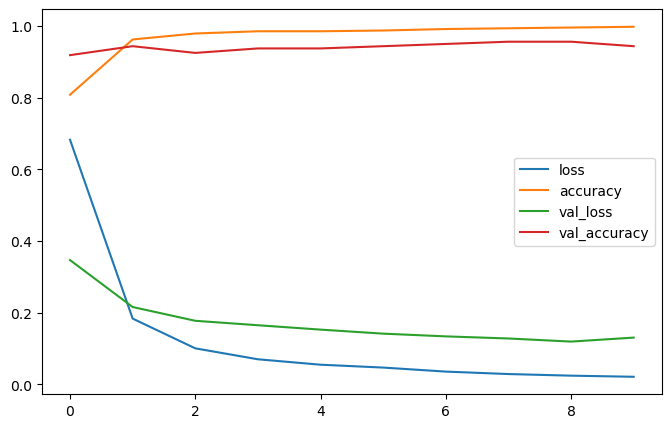

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()